In [4]:
import numpy as np
import jax.numpy as jnp


from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
from circuitmap import NeuralDemixer

import h5py
import sys
sys.path.append('../')
import grid_utils as util
import subtract_utils as subtract_utils
%reload_ext subtract_utils
import os
import glob

plt.rcParams['figure.dpi'] = 300


In [55]:
# data_path = '../data/masato/SST_tdt_synapsin_chrome2f/preprocessed/220725_SSTtDT_hSynDOchrm2fGc8_IC_072522_InVivo_Cell2_A_grid_cmFormat.mat'
data_path = '../preprocessing/test_out.mat'

In [56]:
with h5py.File(data_path) as f:
    pscs = np.array(f['pscs']).T
    stim_mat = np.array(f['stimulus_matrix']).T
    targets = np.array(f['targets']).T
    powers = np.max(stim_mat, axis=0)
    npulses = np.array(f['num_pulses_per_holo'], dtype=int).item()

In [23]:
stim_mat

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [38]:
# separate data by pulses
def separate_by_pulses(stim_mat, pscs, npulses):
    stim_mat_list = [stim_mat[:,i::npulses] for i in range(npulses)]
    pscs_list = [pscs[i::npulses,:] for i in range(npulses)]
    return stim_mat_list, pscs_list

stim_mat_list, pscs_list = separate_by_pulses(stim_mat, pscs, npulses)
powers = np.max(stim_mat_list[0], axis=0)
    

In [36]:

demixer_checkpoint = '../../circuit_mapping/demixers/nwd_ee_ChroME1.ckpt'
results = subtract_utils.run_subtraction_pipeline(
    pscs,
    powers,
    targets,
    stim_mat,
    demixer_checkpoint,
    separate_by_power=False,
    rank=1,)
dset_name = os.path.basename(data_path).split('.')[0]

/Users/bantin/Documents/Columbia/Projects/2p-opto/mbcs_grids/e_to_sst_maps/../subtractr.py:52: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  V_post = np.linalg.lstsq(U_stim, pscs_truncated)[0]


In [42]:
t1 = np.zeros_like(results['raw_map'])
t1[0,...] = 0
t1[1,...] = 5
t1[2,...] = 10

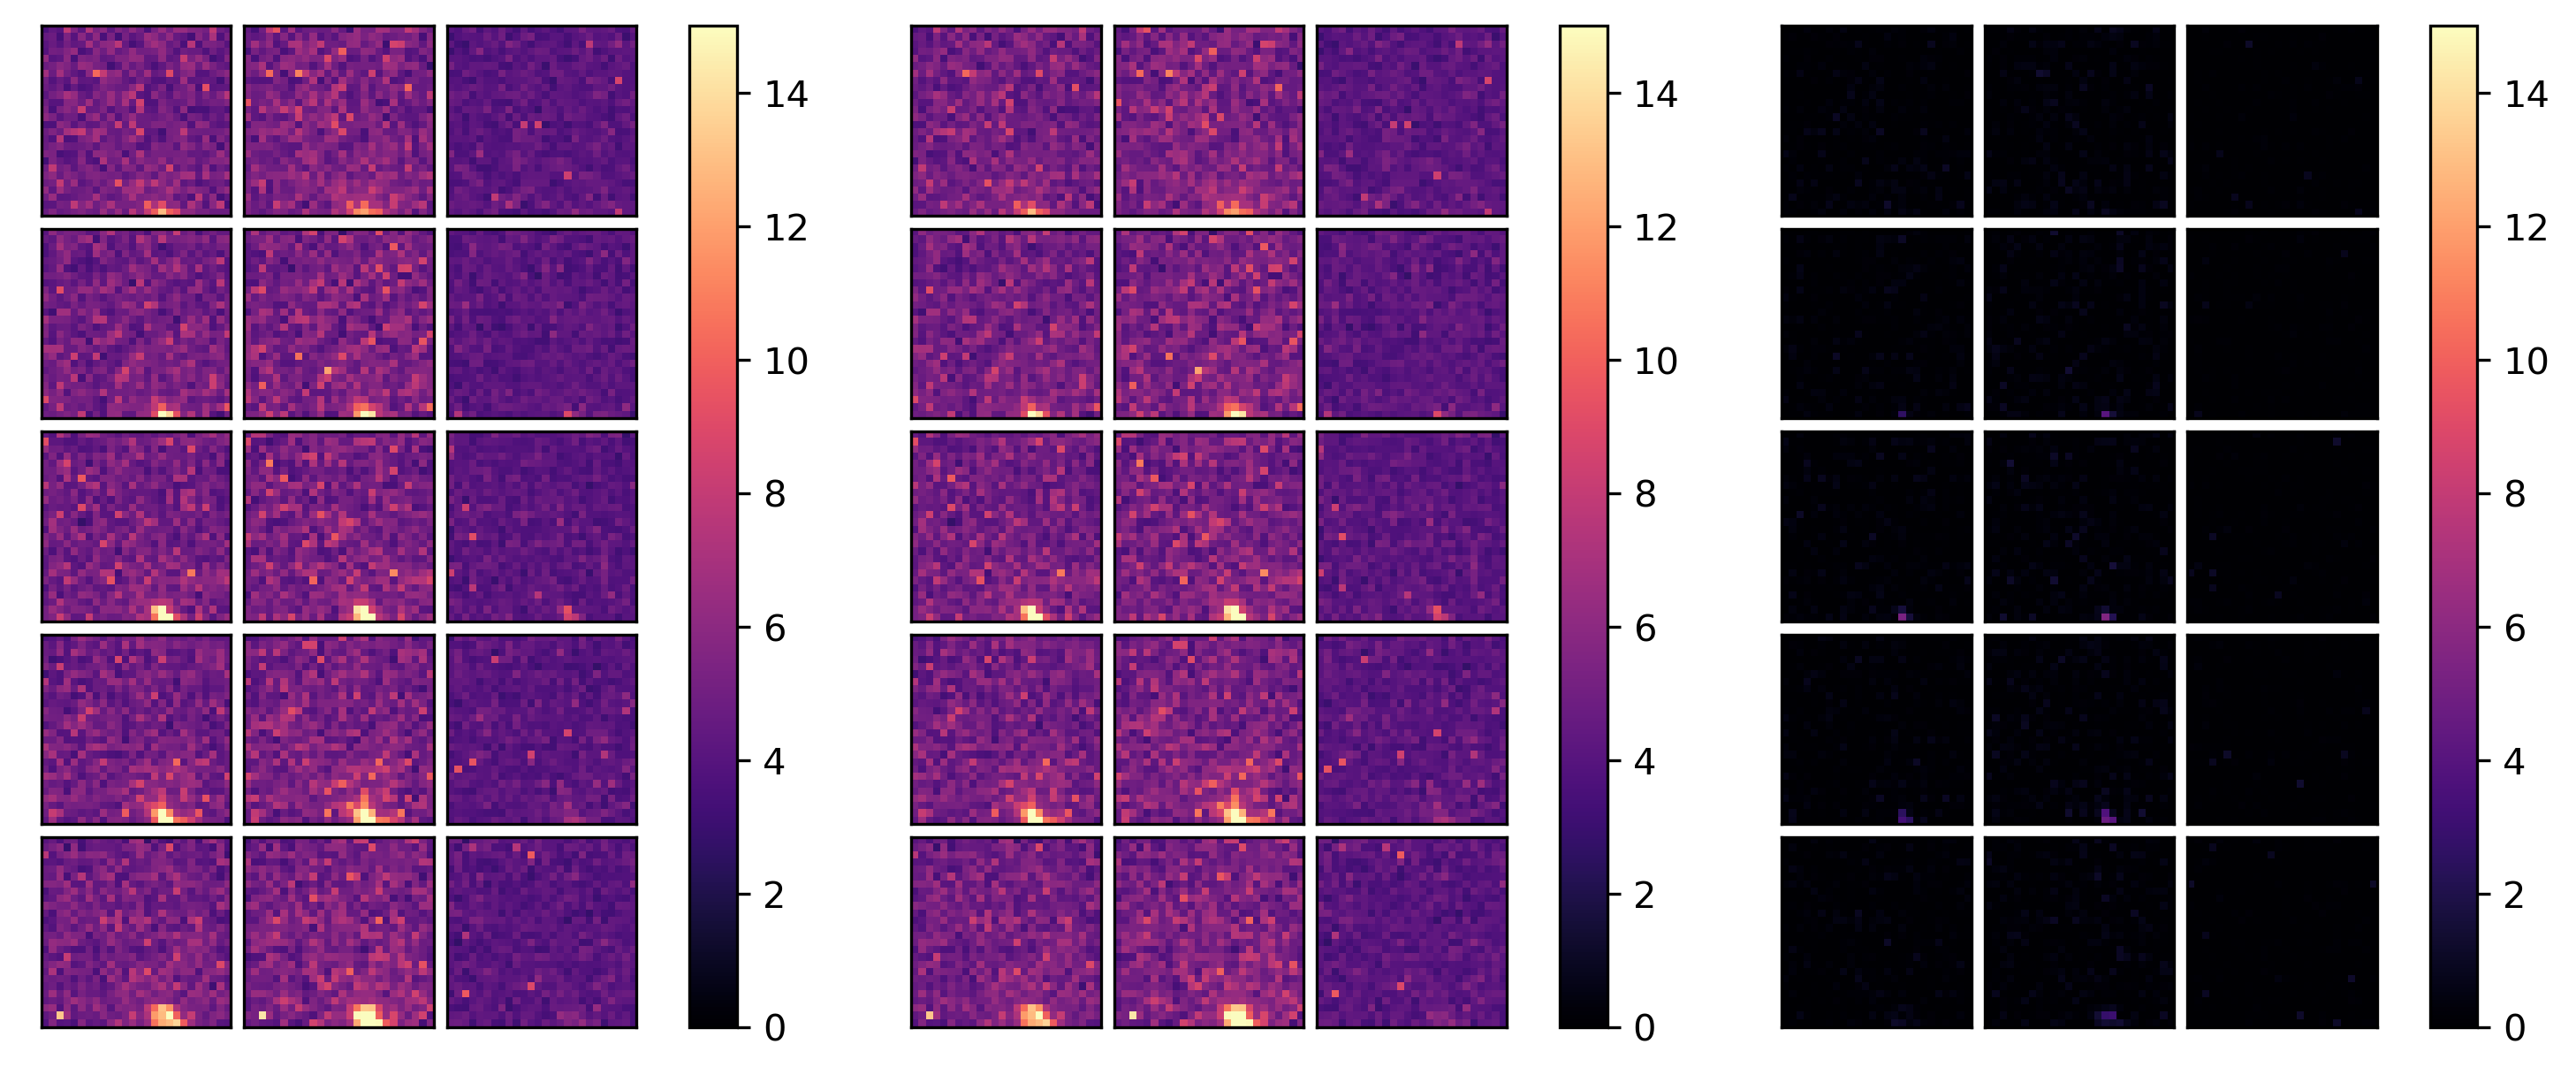

In [51]:
num_planes = results['raw_map'].shape[-1]
fig2 = plt.figure(figsize=(4 * 3, num_planes), dpi=300, facecolor='white')

util.plot_multi_means(fig2,
    [results['raw_map'], results['subtracted_map'], results['demixed_map']], 
    np.arange(num_planes),
#     map_names=['subtracted'],
    cmaps=['magma', 'magma', 'magma'],
    # cbar_labels=['EPSQ (nC)'],
    # zlabels=['subtr', 'demix'],
    # map_names=['raw', 'subtr', 'demix'],
    vranges=[(0,15), (0,15), (0,15)],
)

# plt.savefig(dset_name + '_map_' + '_unconstrained_V_baseline' + '.png', bbox_inches='tight')
plt.show()

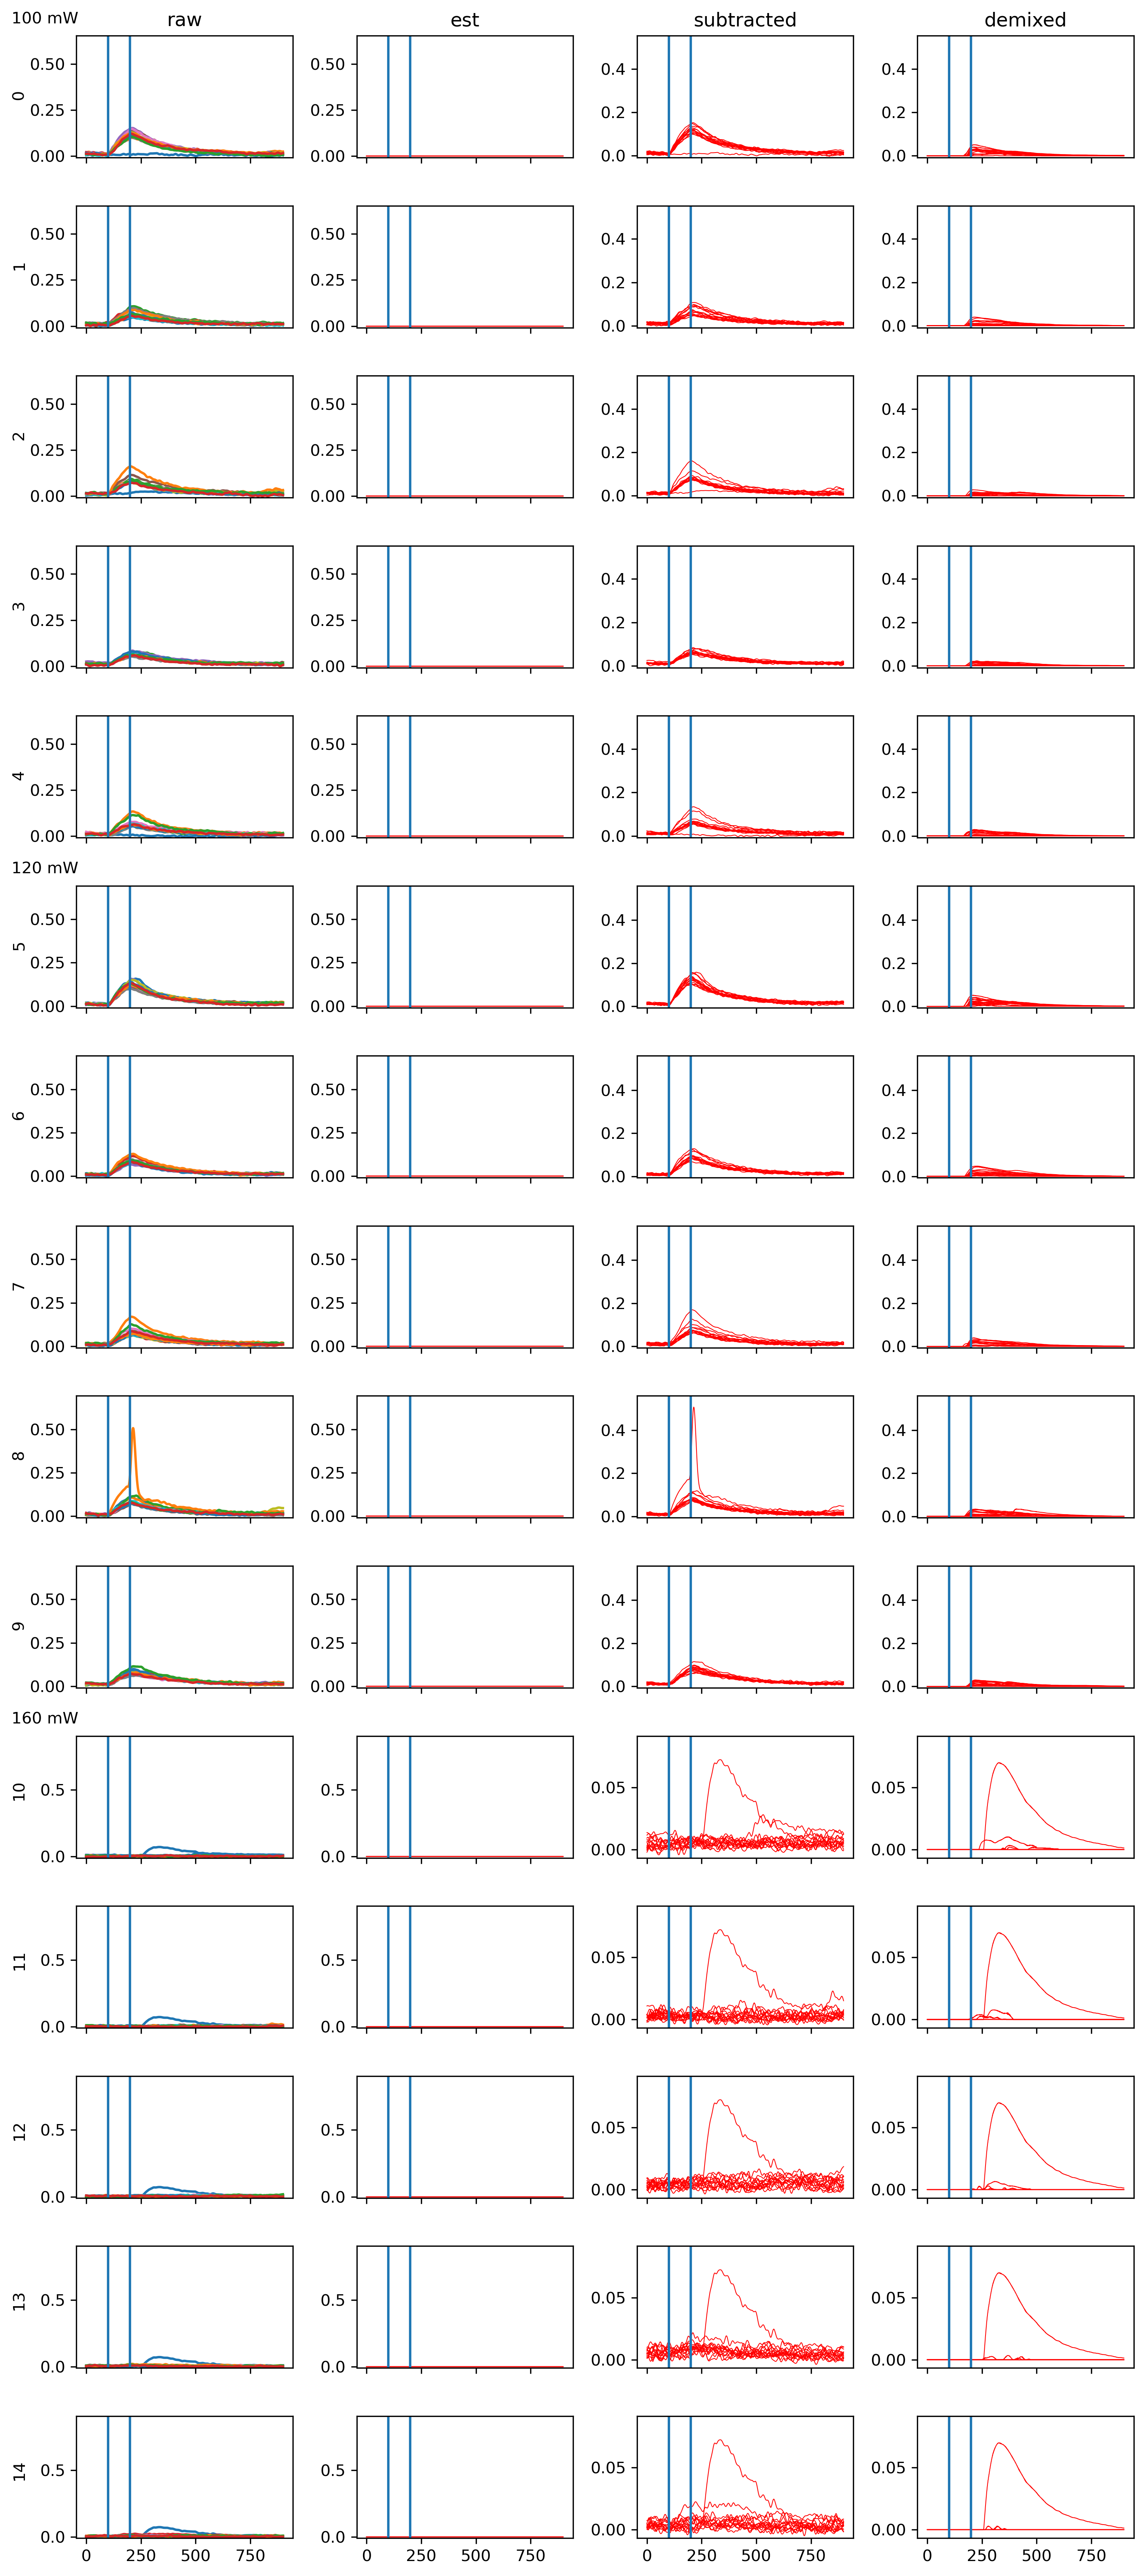

In [54]:

# %matplotlib widget
fig3, axs = subtract_utils.plot_subtraction_comparison(
        results['raw_tensor'],
        [results['est_tensor']],
        [results['subtracted_tensor']],
        [results['demixed_tensor']],
        powers=np.unique(powers),
        num_plots_per_power=5,
        sort_by='demixed',
)
# plt.savefig(dset_name + '_traces_' + '_unconstrained_V_baseline' + '.png', bbox_inches='tight')
plt.show()